# Math 377 Fall 2018

#### Name: Michael Triner
#### Section: M2 Lt Col Horton

**Documentation Statement:** Notes from class, EdX, Inferential Thinking Text

# Project: Predicting Spam
### Data Collection, Summarization, Inference and Prediction

<img style="float: right;" src="img\spam3.jpg">
This project is designed to cover many of the main ideas of the entire course. Ultimately we want to predict if an email is spam. In the course of doing this, we will collect data, clean it up, work with string data, make a simple inference, and then build a naive bayes model from the ground up. 


By the end of project, you should know how to:

1. Find and import data.
2. Use regular expressions to edit string data.
3. Determine if a word helps to identify an email as spam or not.
4. Create a function to predict the type of email using the ideas of Bayesian Classification.
5. Assess your model and propose improvements.

**Advice.** Develop your answers incrementally. To perform a complicated table manipulation, break it up into steps, perform each step on a different line, give a new name to each result, and check that each intermediate result is what you expect by displaying it. You can add additional names or functions to the provided cells in order to organize your work. 

**Authorized Resources:** Anyone and anything.

### 0. Notebook Setup  

Create a folder on your local drive and place this notebook in it. Create a subfolder called `data` copy the file `subject_lines.csv` into it from our Google drive. Create another subfolder called `img` and copy `spam3.jpg` into it, this file can also be found on the Google drive.

### 1. Background Information 

There are a couple of reference papers that may be of interest to explore. The first is "Better Bayesian Filtering" by Paul Graham,http://bit.ly/1ycPbiy. The second is "A Plan for Spam" also by Paul Graham, http://bit.ly/1ycPcmA

### 2. Load Packages  

To get started, load `datascience`, `numpy`, `mathplotlib.pyplot`, `math`, `re`, and `pandas`.

In [1]:
# Execute this line as written
import datascience as ds #note the labs use from datascience import * but this is not a good practice
import numpy as np
import pandas as pd
import re
import math
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

### 3. Get Data

We are going to use data from the [Apache SpamAssasian](https://spamassassin.apache.org/) website. In particular we want data from their public corpus; see the readme document at https://spamassassin.apache.org/old/publiccorpus/.

We have provided you with a csv file that contains two columns. The first is the subject line and the second is whether the email is spam.

Read in the data. It can be found on the Google drive with the name `subject_lines.csv`. Don't forget that you have imported the `datascience` package under the alias `ds`. 

In [2]:
# Complete the code to read in the data
Spam_data_table = ds.Table.read_table('subject_lines.csv')
Spam_data_table

Subject Line,Spam
Re: New Sequences Window,False
[zzzzteana] RE: Alexander,False
[zzzzteana] Moscow bomber,False
[IRR] Klez: The Virus That Won't Die,False
Re: Insert signature,False
Re: [zzzzteana] Nothing like mama used to make,False
Re: [zzzzteana] Nothing like mama used to make,False
[zzzzteana] Playboy wants to go out with a bang,False
Re: [zzzzteana] Nothing like mama used to make,False
[zzzzteana] Meaningful sentences,False


Let's get a count of the emails. Use the group command to get a count of spam and ham emails.

In [3]:
# Complete the code
Spam_data_table.group(1)

Spam,count
False,2800
True,500


### 4. Feature Engineering  

We are dealing with string data as our predictor. We first need to clean it up. The choices we make here will potentially have a big impact on the quality of the model. Ideally we would go back and test the sensitivity of our results to these choices.

First we will make all the text lower case. This will ensure that words such as Free and free are viewed as equivalent. This may not be a good idea for spam detection as a word in all capital letters might be more indicative of spam.  

We will be dealing with frequencies in this project but we could also try other ideas such as vector encoding and $n$-grams.

#### Clean Data

We will first get the subject lines in a standard format with lower cases, no punctuation, and the removal of stopwords.

In [4]:
# Example of the function we need. Execute this line
'FREE'.lower()

'free'

Next, we need to tokenize our string. This means to split the string into a list of words. This requires the use of regular expressions, https://docs.python.org/2/library/re.html. 

We will also need to remove stop words. Stop words are common words such as `and` or `we`, that add little predictive ability. We will load the natural langauge tool kit package, `nltk`, to get a list of stop words. If you are having trouble loading the `nltk` package we also provide the stop words as a csv file.

#### Using nltk package, the preferred method

In [5]:
# Execute the following commands
import nltk

nltk.download('stopwords')

# Getting the English stop words from nltk
stop_words = nltk.corpus.stopwords.words('english')

# Printing out the first eight stop words
print(stop_words[:8])

#We will convert our stopwords to a set as set lookup is much faster

stop_words = set(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\C19Michael.Triner\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Unzipping corpora\stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves']


#### Using a csv file, the backup method

In [6]:
stop_words = set(pd.read_csv('stop_words.csv')["stopwords"].tolist())

Strip off unwanted text from subject line

In [7]:
# Execute this line as is
# Using data science table to demenostrate how to make lower case and keep only words and numbers
print(Spam_data_table.take(np.arange(5)))
print("\n")
for subject in Spam_data_table.take(np.arange(5)).column(0):
    print(re.findall("[a-z0-9']+",subject.lower()))

Subject Line                          | Spam
Re: New Sequences Window              | False
[zzzzteana] RE: Alexander             | False
[zzzzteana] Moscow bomber             | False
[IRR] Klez: The Virus That  Won't Die | False
Re: Insert signature                  | False


['re', 'new', 'sequences', 'window']
['zzzzteana', 're', 'alexander']
['zzzzteana', 'moscow', 'bomber']
['irr', 'klez', 'the', 'virus', 'that', "won't", 'die']
['re', 'insert', 'signature']


Let's remove the stop words and split the string into words. We will run some test code on the first 5 lines for illustration.

In [8]:
# Testing code, run this line of code
for subject in Spam_data_table.take(np.arange(5)).column(0):
    final_words = []
    print("Original subject line: ",subject)
    print("Split line: ",re.findall("[a-z0-9']+",subject.lower()))
    words = re.findall("[a-z0-9']+",subject.lower())
    [final_words.append(word) for word in words if word not in stop_words]
    print("Clean line: ",final_words)

Original subject line:  Re: New Sequences Window
Split line:  ['re', 'new', 'sequences', 'window']
Clean line:  ['new', 'sequences', 'window']
Original subject line:  [zzzzteana] RE: Alexander
Split line:  ['zzzzteana', 're', 'alexander']
Clean line:  ['zzzzteana', 'alexander']
Original subject line:  [zzzzteana] Moscow bomber
Split line:  ['zzzzteana', 'moscow', 'bomber']
Clean line:  ['zzzzteana', 'moscow', 'bomber']
Original subject line:  [IRR] Klez: The Virus That  Won't Die
Split line:  ['irr', 'klez', 'the', 'virus', 'that', "won't", 'die']
Clean line:  ['irr', 'klez', 'virus', 'die']
Original subject line:  Re: Insert signature
Split line:  ['re', 'insert', 'signature']
Clean line:  ['insert', 'signature']


#### Subject Line Frequency  

Before going further with inference or prediction, let's summarize the data. We want to count the total number of times a word occurrs in a subject line separately in both the spam and ham data sets. We need to count the word once per subject line.

Write a function to tokenize each subject line. This means reducing to lower case, removing stop words, and then splits into individual words. Use the code in the previous line as an example.

In [10]:
# Complete this function
def token(subject,sw=stop_words):
    final_words = []
    words = re.findall("[a-z0-9']+",subject.lower())
    [final_words.append(word) for word in words if word not in stop_words]
    return set([word for word in final_words])

First let's run some code on a subset, the first 3 lines, of the data. We need to get the subject line column, tokenize it, and then flatten into a list instead of a list of lists.

In [11]:
# Run this code
# Get the first 5 subject lines for spam
spam_subjects = Spam_data_table.where('Spam',True).take(np.arange(5)).column(0)
#Tokenize and then append
spam_words=[]
for subject in spam_subjects[:3]:
    spam_words.append(token(subject,stop_words))
print("List after using token: ",spam_words,"\n")
#Create one long list of words
spam_words = [item for sublist in spam_words for item in sublist]
print("The flattened list: ",spam_words)

List after using token:  [{'pay', 'life', 'insurance'}, {'206', 'guaranteed', 'ilug', '12', 'lbs', 'days', 'lose', '30', '10'}, {'guaranteed', '12', 'lbs', 'days', 'lose', '30', '10', '150', '11'}] 

The flattened list:  ['pay', 'life', 'insurance', '206', 'guaranteed', 'ilug', '12', 'lbs', 'days', 'lose', '30', '10', 'guaranteed', '12', 'lbs', 'days', 'lose', '30', '10', '150', '11']


Now that you have created code to generate a list of spam words taken from the first 3 subject lines, copy and paste the above snippet and modify it below to go through ALL spam. Note that you should no longer print the lists. 

In [57]:
#Get the subject lines for spam
spam_subjects = Spam_data_table.where('Spam',True).take(np.arange(Spam_data_table.where('Spam',True).num_rows)).column(0)
#Tokenize and then append
spam_words=[]
for subject in spam_subjects[:3]:
    spam_words.append(token(subject,stop_words))
#Create one long list of words
spam_words = [item for sublist in spam_words for item in sublist]
print("There are",len(spam_words),"tokenized words in the spam subject lines.")

There are 21 tokenized words in the spam subject lines.


We can tokenize multiple subjects with the apply function.

In [17]:
# Run code
# Using apply function in datascience
Spam_data_table.take(np.arange(5)).with_columns("Subject",Spam_data_table.take(np.arange(5)).apply(token,"Subject Line")).\
drop(0).select("Subject","Spam").relabel("Subject","Subject Line")

Subject Line,Spam
"{'window', 'new', 'sequences'}",False
"{'zzzzteana', 'alexander'}",False
"{'moscow', 'zzzzteana', 'bomber'}",False
"{'klez', 'die', 'irr', 'virus'}",False
"{'signature', 'insert'}",False


Using the snippet above as an example, tokenize all subjects from spam e-mails only.

In [20]:
# Now for the entire table
Spam_data_table_spamonly = Spam_data_table.where('Spam',True)
Spam_data_table_token = Spam_data_table_spamonly.take(np.arange(Spam_data_table_spamonly.num_rows)).with_columns("Subject",Spam_data_table_spamonly.take(np.arange(Spam_data_table_spamonly.num_rows)).apply(token,"Subject Line")).\
drop(0).select("Subject","Spam").relabel("Subject","Subject Line")
Spam_data_table_token

Subject Line,Spam
"{'pay', 'life', 'insurance'}",True
"{'206', 'guaranteed', 'ilug', '12', 'lbs', 'days', 'lose ...",True
"{'guaranteed', '12', 'lbs', 'days', 'lose', '30', '10', ...",True
"{'user', 'example', 'pviqg', 'password', 'zzzz', 'fw', ' ...",True
"{'social', 'guaranteed', 'ilug', '12', 'lbs', 'days', 'l ...",True
"{'information', 'bank', 'account'}",True
"{'500', 'reps', 'company', 'fortune', 'hiring', 'home'}",True
"{'family', 'protected'}",True
"{'bank', 'account', 'important', 'information', 'concern ...",True
"{'multiply', 'base', 'customer'}",True


Now that we've tokenized all of the spam e-mails, get the frequency of each of the words that appears in spam.

In [74]:
# Get counts and frequency
# Flatten first
spam_words = [item for sublist in Spam_data_table_token.column(0) for item in sublist]
# Put into a table
spam_table = ds.Table().with_column('Words',spam_words)
spam_word_counts = spam_table.group(0)
spam_word_counts.show(5)

Words,count
0,1
00,1
000,9
000's,1
02,1


In [75]:
print("There are",spam_word_counts.num_rows,"unique words in the tokenized spam subject lines.")

There are 1135 unique words in the tokenized spam subject lines.


Next we want to create a column that has the subject line frequency of each word. This is the percentage of subject lines in the spam emails that contain the word of interest. We also sort the table from most frequent to least frequent.

In [81]:
# Execute this cell of code
spam_word_counts = spam_word_counts.with_column('Spam Subject Line Frequency',spam_word_counts.column('count')/500).\
set_format("Spam Subject Line Frequency", ds.NumberFormatter(decimals=4))
spam_word_counts

Words,count,Spam Subject Line Frequency
0,1,0.0020
00,1,0.0020
000,9,0.0180
000's,1,0.0020
02,1,0.0020
05,1,0.0020
05775748,1,0.0020
057sxua1524uhkc5,1,0.0020
08,1,0.0020
0989sqj,1,0.0020


To summarize, 9.2% of the subject lines in the spam emails contain the word `ilug`. As a reminder, the vocabulary of words in the spam subject line consists of 2408 words where 1135 are unique words.

In [78]:
spam_word_counts.num_rows

1135

Find the total of the spam word count column in `spam_word_counts`. 

In [82]:
sum_spam_word_counts = np.sum(spam_word_counts.column(1))
sum_spam_word_counts

2408

Some of the words only occur once. Let's look at some of them.

In [85]:
# Create a table of words where the word only occurs once. There should be three columns, word, spam count and frequency.
spam_word_one = spam_word_counts.where(1,ds.are.equal_to(1))
spam_word_one

Words,count,Spam Subject Line Frequency
0,1,0.0020
00,1,0.0020
000's,1,0.0020
02,1,0.0020
05,1,0.0020
05775748,1,0.0020
057sxua1524uhkc5,1,0.0020
08,1,0.0020
0989sqj,1,0.0020
0rvn,1,0.0020


To visualize the results so far, we will use a bar chart. Create a bar chart showing the frequency of the 15 most frequent words that appear in spam subject lines.

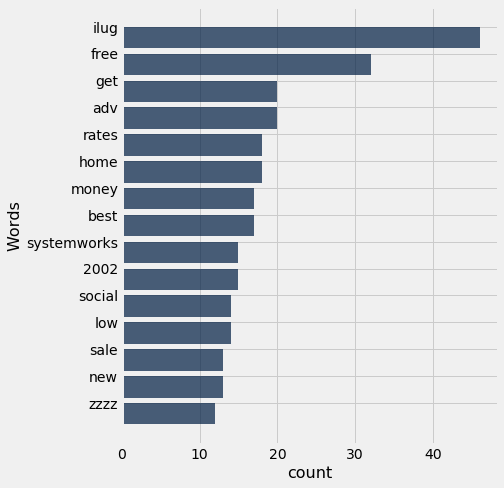

In [91]:
# Create a horizontal bar chart
spam_word_counts.sort(1,descending=True).take(np.arange(15)).barh(0,1)

### Ham e-mails

Repeat this work for the ham e-mails. First, tokenize the ham subject lines.

In [106]:
Ham_data_table_hamonly = Spam_data_table.where('Spam',ds.are.equal_to(False))
Ham_data_table_token = Ham_data_table_hamonly.take(np.arange(Ham_data_table_hamonly.num_rows)).with_columns("Subject",Ham_data_table_hamonly.take(np.arange(Ham_data_table_hamonly.num_rows)).apply(token,"Subject Line")).\
drop(0).select("Subject","Spam").relabel("Subject","Subject Line")
Ham_data_table_token

Subject Line,Spam
"{'window', 'new', 'sequences'}",False
"{'zzzzteana', 'alexander'}",False
"{'moscow', 'zzzzteana', 'bomber'}",False
"{'klez', 'die', 'irr', 'virus'}",False
"{'signature', 'insert'}",False
"{'mama', 'make', 'used', 'nothing', 'like', 'zzzzteana'}",False
"{'mama', 'make', 'used', 'nothing', 'like', 'zzzzteana'}",False
"{'go', 'wants', 'playboy', 'bang', 'zzzzteana'}",False
"{'mama', 'make', 'used', 'nothing', 'like', 'zzzzteana'}",False
"{'sentences', 'zzzzteana', 'meaningful'}",False


Find the word counts for words that appeared in ham subject lines.

In [107]:
# Get counts and frequency
# Flatten first
ham_words = [item for sublist in Ham_data_table_token.column(0) for item in sublist]
# Put into a table
ham_table = ds.Table().with_column('Words',ham_words)
ham_word_counts = ham_table.group(0)
ham_word_counts.show(5)

Words,count
'apt,3
'betrayal',1
'boost,1
'boosts,1
'bust',1


In [108]:
print("There are",ham_word_counts.num_rows,"unique words in the tokenized ham subject lines.")

There are 3727 unique words in the tokenized ham subject lines.


In [109]:
sum_ham_word_counts = np.sum(ham_word_counts.column(1)) 
print("There are",sum_ham_word_counts,"tokenized words in the ham subject lines.")

There are 12163 tokenized words in the ham subject lines.


In [111]:
ham_word_counts = ham_word_counts.with_column('Ham Subject Line Frequency',ham_word_counts.column('count')/2800).\
set_format("Ham Subject Line Frequency", ds.NumberFormatter(decimals=4))
ham_word_counts

Words,count,Ham Subject Line Frequency
'apt,3,0.0011
'betrayal',1,0.0004
'boost,1,0.0004
'boosts,1,0.0004
'bust',1,0.0004
'cancer,1,0.0004
'could,1,0.0004
'em,1,0.0004
'face,1,0.0004
'flexible',1,0.0004


Make a barplot showing the frequency of the 15 most frequent words that appear in ham subject lines. 

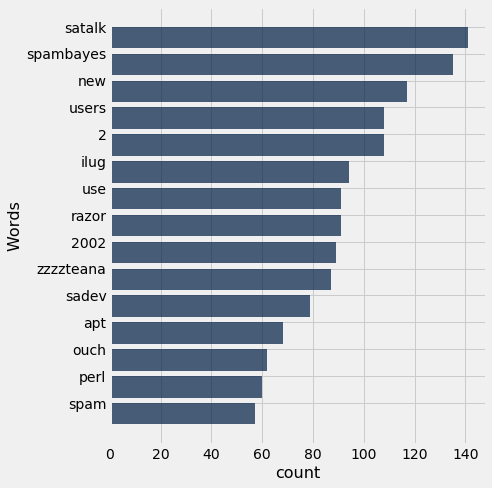

In [112]:
ham_word_counts.sort(1,descending=True).take(np.arange(15)).barh(0,1)

There are 12163 words in the ham email subject lines of which 3727 are unique. Which words appear only once?

In [113]:
ham_word_one = ham_word_counts.where(1,ds.are.equal_to(1))
ham_word_one

Words,count,Ham Subject Line Frequency
'betrayal',1,0.0004
'boost,1,0.0004
'boosts,1,0.0004
'bust',1,0.0004
'cancer,1,0.0004
'could,1,0.0004
'em,1,0.0004
'face,1,0.0004
'flexible',1,0.0004
'flipping',1,0.0004


As a reminder, in the spam subject line there are 1135 unique words while there are 3727 in the ham. When we merge these data sets there will only be partial overlap.

In [114]:
spam_word_counts.num_rows #Number of unique words in spam subject lines

1135

In [115]:
ham_word_counts.num_rows #Number of unique words in ham subject lines

3727

There are many more words in the ham subject lines than in the spam subject lines. We need to get one table with the words and counts. This will increase the number of rows for the spam. The built-in join function from the `datascience` package only performs an inner joining. We need to perform an outer join. We cannot determine how to do this with the join function from `datascience` so let's convert the table to pandas dataframes and then perform an outer join, see https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/. By default, pandas repalces missing values with NaN, not a number. We must replace those missing values with 0. Finally, we can convert back to a datascience table.

In [116]:
# Execute this cell
# Convert data.science table to pandas dataframe
word_counts = pd.merge(ham_word_counts.to_df(),spam_word_counts.to_df(),how="outer").fillna(0)
word_counts = ds.Table.from_df(word_counts)
word_counts

Words,count,Ham Subject Line Frequency,Spam Subject Line Frequency
'apt,3,0.00107143,0
'betrayal',1,0.000357143,0
'boost,1,0.000357143,0
'boosts,1,0.000357143,0
'bust',1,0.000357143,0
'cancer,1,0.000357143,0
'could,1,0.000357143,0
'em,1,0.000357143,0
'face,1,0.000357143,0
'flexible',1,0.000357143,0


Let's visualize the results by looking at the most common words in the ham subject lines.

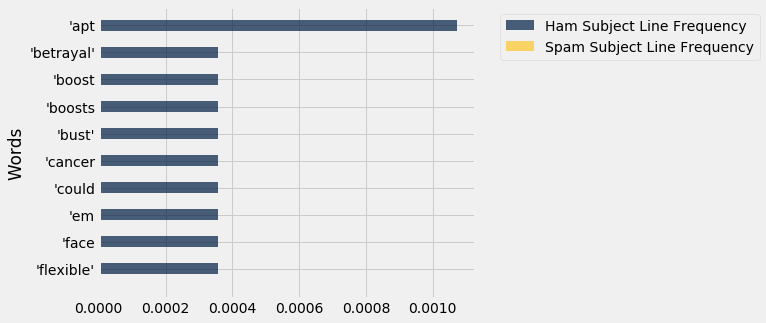

In [117]:
# Execute this cell
word_counts.take(np.arange(10)).select('Words','Ham Subject Line Frequency','Spam Subject Line Frequency').barh('Words')

Now, create the same visualization but with the most common words in the spam emails. 

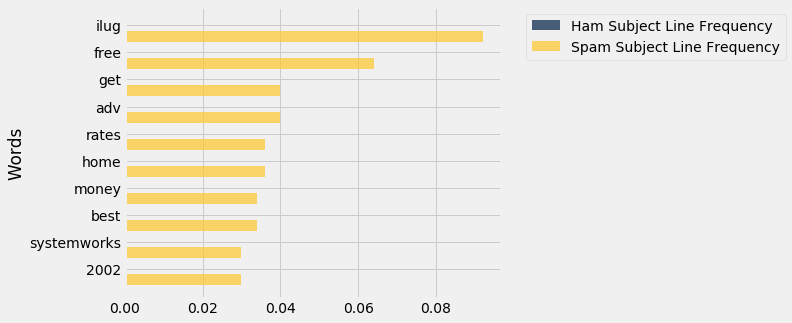

In [120]:
word_counts.sort(3,descending=True).take(np.arange(10)).select('Words','Ham Subject Line Frequency','Spam Subject Line Frequency').barh('Words')

What do you notice about words that appear in spam and ham e-mail subject lines? 

none of them are the same, the most common words in Ham and Spam Subject lines are unique when compared to one-another.

#### References


https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/
http://localhost:8888/notebooks/Documents/Classes/Books/Stats/Python%20Data%20Science%20Handbook/PythonDataScienceHandbook-master/notebooks/05.05-Naive-Bayes.ipynb